In [3]:
import chart_studio
import chart_studio.plotly as py
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as pyo
from pyspark.sql import DataFrame, SparkSession
import pyspark.sql.functions as F
from venn import venn

spark = (
    SparkSession.builder.master('local[*]')
    .config("spark.driver.memory", "15g")
    .config('spark.ui.showConsoleProgress', 'false')
    .appName('spark')
    .getOrCreate()
)


chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [4]:
def drop_null_columns(df: DataFrame) -> DataFrame:
    """Drops all columns which only contain null values."""
    df_count = df.count()
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v == df_count]
    return df.drop(*to_drop)

In [5]:
ROOT = Path.cwd().parent

In [6]:
SOURCES_OF_INTEREST = ['REGENERON', 'AstraZeneca PheWAS Portal', 'Genebass']

# UPDATE: use therapeutic are to distinguish between binary and quantitative traits
diseases = spark.read.parquet(Path.joinpath(ROOT / 'data/diseases').as_posix()).select('id', 'name', 'ancestors', 'therapeuticAreas')
evd = drop_null_columns(
    spark.read.parquet(Path.joinpath(ROOT / 'data/gene_burden_evidence').as_posix()).filter(F.col('projectId').isin(SOURCES_OF_INTEREST))
    .join(diseases.selectExpr('id as diseaseId', 'therapeuticAreas'), on='diseaseId', how='left')
    .coalesce(1)
)
regeneron_evd = evd.filter(F.col('projectId') == 'REGENERON')
az_evd = evd.filter(F.col('projectId') == 'AstraZeneca PheWAS Portal')
genebass_evd = evd.filter(F.col('projectId') == 'Genebass')


# regeneron_raw = read_regeneron('data/41586_2021_4103_MOESM5_ESM.xlsx')
# az_raw = read_az('data/azphewas-com-450k-phewas-binary', 'data/azphewas-com-450k-phewas-quantitative')


23/02/27 12:39:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## General outline of the comparative analysis between both results

- General statistics (table).
- Nº assocs binary/quant, genes, binary/quant phenotypes, overlaps.
- Model comparison.
- Ancestry specificity.


### 1. General statistics

In [7]:
dfs = [('REGENERON', regeneron_evd), ('AZ', az_evd), ('Genebass', genebass_evd)]

for (name, df) in dfs:
    print(f"# of {name} evd: {df.count()}")
    print(f"# of {name} distinct targets: {df.select('targetId').distinct().count()}")
    print(f"# of {name} distinct mapped diseases: {df.select('diseaseFromSourceMappedId').distinct().count()}")
    print(f"# of {name} distinct raw diseases: {df.select('diseaseFromSource').distinct().count()}")
    print(
        f"... of which are quantitative: {df.filter(F.array_contains('therapeuticAreas', 'EFO_0001444')).select('diseaseFromSource').distinct().count()}"
    )
    print(
        f"... of which are binary: {df.filter(~F.array_contains('therapeuticAreas', 'EFO_0001444')).select('diseaseFromSource').distinct().count()}"
    )
    print('-' * 80)
    print(
        f"# of {name} assocs (considering different disease terms): {df.select('diseaseFromSourceMappedId', 'targetId').distinct().count()}"
    )
    print(f"# of {name} assocs: {df.select('diseaseId', 'targetId').distinct().count()}")
    print(
        f"# of {name} assocs with quant traits: {df.filter(F.array_contains('therapeuticAreas', 'EFO_0001444')).select('diseaseId', 'targetId').distinct().count()}"
    )
    print(
        f"# of {name} assocs with binary traits: {df.filter(~F.array_contains('therapeuticAreas', 'EFO_0001444')).select('diseaseId', 'targetId').distinct().count()}"
    )
    print(
        f"# of {name} collapsing models: {df.select('statisticalMethod').distinct().count()} {regeneron_evd.select('statisticalMethod').distinct().toPandas()['statisticalMethod'].to_list()}"
    )
    print('-' * 100)

# of REGENERON evd: 7382
# of REGENERON distinct targets: 483
# of REGENERON distinct mapped diseases: 205
# of REGENERON distinct raw diseases: 427
... of which are quantitative: 213
... of which are binary: 216
--------------------------------------------------------------------------------
# of REGENERON assocs (considering different disease terms): 1397
# of REGENERON assocs: 1397
# of REGENERON assocs with quant traits: 1168
# of REGENERON assocs with binary traits: 229
# of REGENERON collapsing models: 10 ['ADD-WGR-FIRTH_M3.1', 'ADD-WGR-FIRTH_M1.001', 'ADD-WGR-FIRTH_M3.001', 'ADD-WGR-FIRTH_M1.singleton', 'ADD-WGR-FIRTH_M3.0001', 'ADD-WGR-FIRTH_M1.1', 'ADD-WGR-FIRTH_M1.01', 'ADD-WGR-FIRTH_M3.01', 'ADD-WGR-FIRTH_M1.0001', 'ADD-WGR-FIRTH_M3.singleton']
----------------------------------------------------------------------------------------------------
# of AZ evd: 11767
# of AZ distinct targets: 713
# of AZ distinct mapped diseases: 431
# of AZ distinct raw diseases: 1095
... of whi

### 2. Overlap

In [8]:
# OVERLAP

az_assocs = az_evd.select('diseaseId', 'targetId').distinct()
regeneron_assocs = regeneron_evd.select('diseaseId', 'targetId').distinct()
genebass_assocs = genebass_evd.select('diseaseId', 'targetId').distinct()



In [9]:
# I want to expand the ontology to adress for differences in the mapping
# For that, I will use the disease index

diseases = (
        diseases
        # expanded_id will include its id and all its ancestors
        .withColumn('expanded_id', F.array_union(F.array(F.col('id')), F.col('ancestors')))
        .select('id', 'name', 'expanded_id', 'ancestors')
)

diseases.show(1, False, True)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id          | EFO_0000255                                                                                                                                                                                                                                                                                    
 name        | angioimmunoblastic T-cell lymphoma                                                                                                                                                                                                                                                             
 expanded_id | [EFO_0000255, MONDO_0000430, OTAR_0000018, MONDO_0002334, MONDO_0023370, MON

Text(0.5, 1.0, 'Overlap of traits after mapping to EFO')

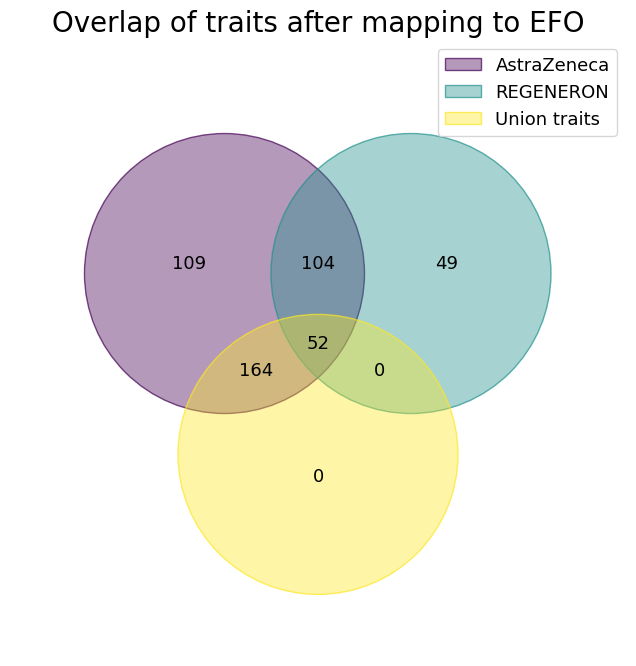

In [10]:
# Simple mapped trait overlap

# Here we see that the excess in AZ is largely due to the unions.
# However, although REGENERON doesn't aggregate traits into union of phenotypes, it does have some.

trait_simple_overlap_sets = {
    'AstraZeneca': set(
        az_assocs.select('diseaseId').toPandas()['diseaseId'].tolist()
    ),
    'REGENERON': set(
        regeneron_assocs.select('diseaseId').toPandas()['diseaseId'].tolist()
    ),
    'Union traits': set(
        az_assocs.filter(F.col('diseaseFromSource').startswith('Union')).select('diseaseId').toPandas()['diseaseId'].tolist()
    ),
}

venn(trait_simple_overlap_sets, legend_loc="best")
plt.title('Overlap of traits after mapping to EFO', fontsize=20)


Text(0.5, 1.0, 'Overlap of traits after mapping to EFO')

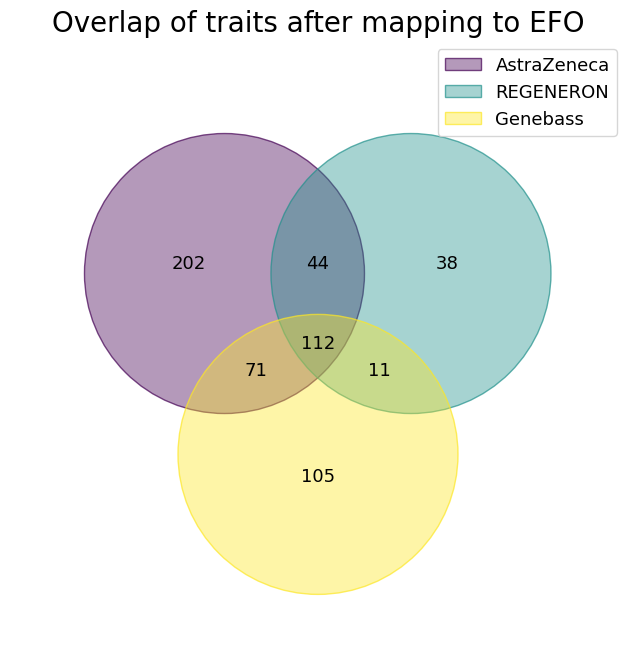

In [11]:
trait_simple_overlap_sets = {
    'AstraZeneca': set(
        az_assocs.select('diseaseId').toPandas()['diseaseId'].tolist()
    ),
    'REGENERON': set(
        regeneron_assocs.select('diseaseId').toPandas()['diseaseId'].tolist()
    ),
    'Genebass': set(
        genebass_assocs.select('diseaseId').toPandas()['diseaseId'].tolist()
    ),
}


venn(trait_simple_overlap_sets, legend_loc="best")
plt.title('Overlap of traits after mapping to EFO', fontsize=20)

In [10]:
# Non overlapping REGENERON traits - it doesn't seem to be due to a selection criterion
(
    regeneron_assocs.select('diseaseId')
    .join(az_assocs.select('diseaseId'), on='diseaseId', how='left_anti').distinct()
    .join(regeneron_evd.select('diseaseId', 'diseaseFromSource'), on='diseaseId', how='inner').distinct()
    .show(truncate=False)
)

+-----------+-----------------------------------------------------------------------------------------+
|diseaseId  |diseaseFromSource                                                                        |
+-----------+-----------------------------------------------------------------------------------------+
|EFO_0000546|ICD10 Y43.3: Adverse effects in the therapeutic use of other antineoplastic drugs (Y43.3)|
|EFO_0000546|ICD10 Y43: Adverse effects in the therapeutic use of primarily systemic agents (Y43)     |
|EFO_0000689|Touchscreen duration (630)                                                               |
|EFO_0002427|ICD10 C92: Myeloid leukemia                                                              |
|EFO_0002686|Atopy CC (RGC)                                                                           |
|EFO_0003784|Skin colour - Very fair (1717)                                                           |
|EFO_0003784|Skin colour - Light olive (1717)                   

In [11]:
# Non overlapping AZ traits - 191/265 refer to Union phenotypes
(
    az_assocs.select('diseaseId')
    .join(regeneron_assocs.select('diseaseId'), on='diseaseId', how='left_anti').distinct()
    .join(az_evd.select('diseaseId', 'diseaseFromSource'), on='diseaseId', how='inner')
    .filter(F.col('diseaseFromSource').startswith('Union'))
    .select('diseaseId').distinct()
    .count()
)

191

In [12]:
regeneron_evd.filter(F.col('diseaseFromSource').startswith('Union')).select('diseaseFromSource').distinct().count()

0

Text(0.5, 1.0, 'Gene/disease associations overlap')

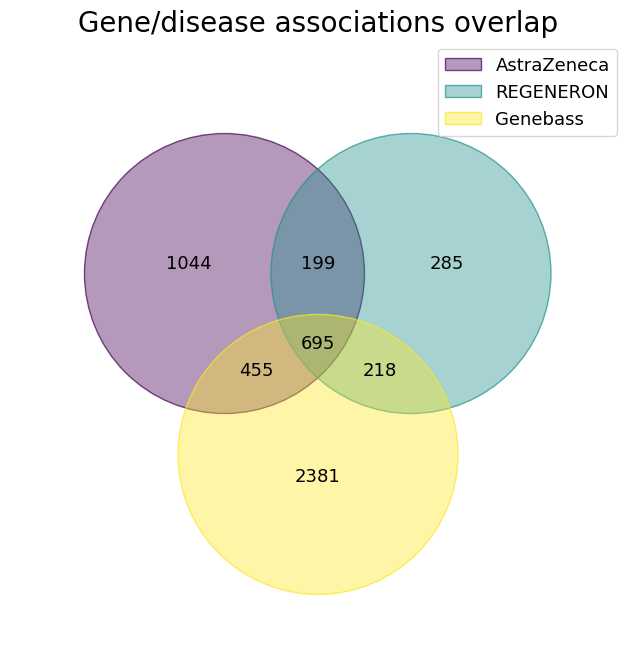

In [12]:
assoc_overlap_sets = {
    'AstraZeneca': set(
        az_assocs.withColumn('assoc', F.concat('targetId', F.lit('|'), 'diseaseId')).toPandas()['assoc'].tolist()
    ),
    'REGENERON': set(
        regeneron_assocs.withColumn('assoc', F.concat('targetId', F.lit('|'), 'diseaseId')).toPandas()['assoc'].tolist()
    ),
    'Genebass': set(
        genebass_assocs.withColumn('assoc', F.concat('targetId', F.lit('|'), 'diseaseId')).toPandas()['assoc'].tolist()
    ),
}

venn(assoc_overlap_sets, legend_loc="best")
plt.title('Gene/disease associations overlap', fontsize=20)


### # OF ASSOCIATIONS PER GENE

I want to remove from the list the diseases that are ancestors of other diseases, so that the metric is not contaminated

**--> TODO: REMOVE ANCESTORS**

**I haven't found a way to do that yet, but I estimate the impact is not large - as it affects 262/851 targets and the difference is not significantly large (next cell)**

In [14]:
'''
I want to remove from the list the diseases that are ancestors of other diseases, so that the metric is not contaminated

I haven't found a way to do that yet, but I estimate the impact is not large - as it affects 262/851 targets and the difference is not significantly large
'''


(
    evd.groupBy('targetId').agg(F.collect_set('diseaseId').alias('associated_diseases'))
    
    # i want to remove from the list the diseases that are ancestors of other diseases, so that the metric is not contaminated
    .withColumn('disease', F.explode('associated_diseases'))
    .join(diseases.withColumnRenamed('id', 'disease').select('disease', 'ancestors'), on='disease', how='left')

    .withColumn('associated_diseases_clean', F.array_except(F.col('associated_diseases'), F.col('ancestors')))

    .withColumn('diff_after_removing_ancestors', F.size('associated_diseases') - F.size('associated_diseases_clean'))
    .filter(F.col('diff_after_removing_ancestors') > 0)

    # associated_diseases_clean hosts the list of associated diseases without the ancestor for the given disease
    # I have to group the data again on the target, and collect the list of these lists
    # flatten them and remove the duplicates
    #.groupBy('targetId', 'associated_diseases').agg(F.collect_set('associated_diseases_clean').alias('associated_diseases_clean_lists'))
    #.withColumn('agg_associated_diseases_clean', F.array_distinct(F.flatten('associated_diseases_clean_lists')))

    .show(3, False, True)
)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 disease                       | EFO_0007986                                                                                                                                                                                                                                                                                                                                         
 targetId                      | ENSG00000004939                                                                                                                                                                                                            

In [10]:
print(
    f"Average # of associations per gene in total: {evd.select('targetId', 'diseaseId').distinct().groupBy('targetId').count().agg({'count': 'mean'}).toPandas()['avg(count)'][0]}"
)
print(
    f"... in REGENERON: {regeneron_assocs.groupBy('targetId').count().agg({'count': 'mean'}).toPandas()['avg(count)'][0]}"
)
print(f"... in AZ: {az_assocs.groupBy('targetId').count().agg({'count': 'mean'}).toPandas()['avg(count)'][0]}")
print(
    f"... in Genebass: {genebass_assocs.groupBy('targetId').count().agg({'count': 'mean'}).toPandas()['avg(count)'][0]}"
)


print(
    f"Median # of associations per gene in total: {evd.select('targetId', 'diseaseId').distinct().groupBy('targetId').count().agg(F.expr('percentile_approx(count, 0.5)').alias('median')).toPandas()['median'][0]}"
)
print(
    f"... in REGENERON: {regeneron_assocs.groupBy('targetId').count().agg(F.expr('percentile_approx(count, 0.5)').alias('median')).toPandas()['median'][0]}"
)
print(
    f"... in AZ: {az_assocs.groupBy('targetId').count().agg(F.expr('percentile_approx(count, 0.5)').alias('median')).toPandas()['median'][0]}"
)
print(
    f"... in Genebass: {genebass_assocs.groupBy('targetId').count().agg(F.expr('percentile_approx(count, 0.5)').alias('median')).toPandas()['median'][0]}"
)


Average # of associations per gene in total: 2.989801699716714
... in REGENERON: 2.8923395445134576
... in AZ: 3.356241234221599
... in Genebass: 2.610724233983287
Median # of associations per gene in total: 1
... in REGENERON: 2
... in AZ: 2
... in Genebass: 1


### # NUMBER OF GENES PER TRAIT

To test for poligenicity and analyse the hypothesis that common and rare variation have a similar genetic architecture.

In [12]:
print(
    f"Average # of genes associated with a trait in total: {evd.select('targetId', 'diseaseId').distinct().groupBy('diseaseId').count().agg({'count': 'mean'}).toPandas()['avg(count)'][0]}"
)
print(
    f"... in REGENERON: {regeneron_assocs.groupBy('diseaseId').count().agg({'count': 'mean'}).toPandas()['avg(count)'][0]}"
)
print(f"... in AZ: {az_assocs.groupBy('diseaseId').count().agg({'count': 'mean'}).toPandas()['avg(count)'][0]}")
print(
    f"... in Genebass: {genebass_assocs.groupBy('diseaseId').count().agg({'count': 'mean'}).toPandas()['avg(count)'][0]}"
)


print(
    f"Median # of genes associated with a trait in total: {evd.select('targetId', 'diseaseId').distinct().groupBy('diseaseId').count().agg(F.expr('percentile_approx(count, 0.5)').alias('median')).toPandas()['median'][0]}"
)
print(
    f"... in REGENERON: {regeneron_assocs.groupBy('diseaseId').count().agg(F.expr('percentile_approx(count, 0.5)').alias('median')).toPandas()['median'][0]}"
)
print(
    f"... in AZ: {az_assocs.groupBy('diseaseId').count().agg(F.expr('percentile_approx(count, 0.5)').alias('median')).toPandas()['median'][0]}"
)
print(
    f"... in Genebass: {genebass_assocs.groupBy('diseaseId').count().agg(F.expr('percentile_approx(count, 0.5)').alias('median')).toPandas()['median'][0]}"
)


Average # of genes associated with a trait in total: 9.051457975986278
... in REGENERON: 6.814634146341463
... in AZ: 5.578088578088578
... in Genebass: 12.538461538461538
Median # of genes associated with a trait in total: 2
... in REGENERON: 2
... in AZ: 2
... in Genebass: 3


### 3. Model comparison

In [13]:
## # OF ASSOCIATIONS PER MODEL

'''
Common (MAF >= 1%): >= 1%
rare: < 1%
Very rare (MAF < 0.1%): < 0.1%
Ultra rare: < 0.01%

M1 -> pLOF / M3 -> pLOF and missense
'''

MODEL_TO_MAF = {
    'ptv': 'Very rare (MAF < 0.1%)',
    'ptv5pcnt': 'Common (MAF >= 1%)',
    'UR': 'Ultra rare (MAF < 0.01%)',
    'URmtr': 'Ultra rare (MAF < 0.01%)',
    'raredmg': 'Ultra rare (MAF < 0.01%)',
    'raredmgmtr': 'Ultra rare (MAF < 0.01%)',
    'flexdmg': 'Ultra rare (MAF < 0.01%)',
    'flexnonsyn': 'Ultra rare (MAF < 0.01%)',
    'flexnonsynmtr': 'Ultra rare (MAF < 0.01%)',
    'ptvraredmg': 'Ultra rare (MAF < 0.01%)',
    'rec': 'Common (MAF >= 1%)',
    'M1.singleton': 'Ultra rare (MAF < 0.01%)',
    'M1.0001': 'Ultra rare (MAF < 0.01%)',
    'M1.001': 'Ultra rare (MAF < 0.01%)',
    'M1.01': 'Very rare (MAF < 0.1%)',
    'M1.1': 'Rare (MAF < 1%)',
    'M3.singleton': 'Ultra rare (MAF < 0.01%)',
    'M3.0001': 'Ultra rare (MAF < 0.01%)',
    'M3.001': 'Ultra rare (MAF < 0.01%)',
    'M3.01': 'Very rare (MAF < 0.1%)',
    'M3.1': 'Rare (MAF < 1%)',
    'ADD-WGR-FIRTH_M1.singleton': 'Ultra rare (MAF < 0.01%)',
    'ADD-WGR-FIRTH_M1.0001': 'Ultra rare (MAF < 0.01%)',
    'ADD-WGR-FIRTH_M1.001': 'Ultra rare (MAF < 0.01%)',
    'ADD-WGR-FIRTH_M1.01': 'Very rare (MAF < 0.1%)',
    'ADD-WGR-FIRTH_M1.1': 'Rare (MAF < 1%)',
    'ADD-WGR-FIRTH_M3.singleton': 'Ultra rare (MAF < 0.01%)',
    'ADD-WGR-FIRTH_M3.0001': 'Ultra rare (MAF < 0.01%)',
    'ADD-WGR-FIRTH_M3.001': 'Ultra rare (MAF < 0.01%)',
    'ADD-WGR-FIRTH_M3.01': 'Very rare (MAF < 0.1%)',
    'ADD-WGR-FIRTH_M3.1': 'Rare (MAF < 1%)',
    'pLoF': 'Ultra rare (MAF < 0.01%)',
    'missense|LC': 'Ultra rare (MAF < 0.01%)',
    'synonymous': 'Ultra rare (MAF < 0.01%)',
    'pLoF|missense|LC': 'Ultra rare (MAF < 0.01%)'

}

assocs_per_model = (
    evd.select('statisticalMethod', F.concat_ws('|', 'diseaseId', 'targetId'), 'projectId')
    .withColumn('mafThreshold', F.col('statisticalMethod'))
    .replace(to_replace=MODEL_TO_MAF, subset=['mafThreshold'])
    .groupBy('statisticalMethod', 'projectId', 'mafThreshold')
    .count()
    .toPandas()
    .sort_values(by='count', ascending=False)
)

fig1= px.bar(
    assocs_per_model,
    x='statisticalMethod',
    y='count',
    color='projectId',
    height=500,
    title='Distribution of associations per collapsing model',
    labels={'statisticalMethod': 'Model', 'count': 'Association count', 'projectId': 'Project'},
)

fig1.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))


In [14]:
fig2 = px.bar(
    assocs_per_model,
    x='statisticalMethod',
    y='count',
    color='mafThreshold',
    #pattern_shape='projectId',
    height=500,
    title='Distribution of associations per collapsing model',
    hover_data=["projectId", "statisticalMethod", "count", 'mafThreshold'],
    labels={'projectId': 'Source', 'statisticalMethod': 'Model', 'count': 'Association count', 'mafThreshold': 'Minor Allele frequency'},
    category_orders={'mafThreshold': ['Ultra rare (MAF < 0.01%)', 'Very rare (MAF < 0.1%)', 'Rare (MAF < 1%)', 'Common (MAF >= 1%)']},
)

fig2.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

py.plot(fig2, filename = 'assocs_per_model', auto_open=True)

'https://plotly.com/~irenelopezs/1/'

### 4. Directions of effect

1. Different directions of effect decrease the statistical power of the analysis.
I want to get 10 overlapping genes/disease pairs and stack them to see if directions are equal.

In [15]:
common_assocs = (
    regeneron_evd
    .filter(F.col('beta').isNotNull())
    .select(F.concat_ws('|', 'diseaseId', 'targetId').alias('associationId'))
    
    .join(
        az_evd.filter(F.col('beta').isNotNull())
        .select(F.concat_ws('|', 'diseaseId', 'targetId').alias('associationId')),
        on='associationId', how='inner'
    )

    .join(
        genebass_evd.filter(F.col('beta').isNotNull())
        .select(F.concat_ws('|', 'diseaseId', 'targetId').alias('associationId')),
        on='associationId', how='inner'
    )
    .distinct()
)

regeneron_common_effects = (
    regeneron_evd.select(F.concat_ws('|', 'diseaseId', 'targetId').alias('associationId'), 'projectId', 'beta', 'score', 'statisticalMethod')
    .join(common_assocs, on='associationId', how='inner').distinct()

    # We'll have multiple values due to multiple models - we'll take the mean
    #.groupBy('associationId', 'projectId').agg(F.mean('beta').alias('beta'))
)

az_common_effects = (
    az_evd.select(F.concat_ws('|', 'diseaseId', 'targetId').alias('associationId'), 'projectId', 'beta', 'score', 'statisticalMethod')
    .join(common_assocs, on='associationId', how='inner').distinct()
)

genebass_common_effects = (
    genebass_evd.select(F.concat_ws('|', 'diseaseId', 'targetId').alias('associationId'), 'projectId', 'beta', 'score', 'statisticalMethod')
    .join(common_assocs, on='associationId', how='inner').distinct()
)

effects_common_assocs = regeneron_common_effects.union(az_common_effects).union(genebass_common_effects).distinct()

effects_common_assocs.filter(F.col('associationId') == 'EFO_0004532|ENSG00000100031').show(5, truncate=False)
# great!

+---------------------------+---------+------+------------------+--------------------------+
|associationId              |projectId|beta  |score             |statisticalMethod         |
+---------------------------+---------+------+------------------+--------------------------+
|EFO_0004532|ENSG00000100031|REGENERON|-0.982|1.0               |ADD-WGR-FIRTH_M3.001      |
|EFO_0004532|ENSG00000100031|REGENERON|-1.028|1.0               |ADD-WGR-FIRTH_M3.01       |
|EFO_0004532|ENSG00000100031|REGENERON|-1.159|1.0               |ADD-WGR-FIRTH_M3.0001     |
|EFO_0004532|ENSG00000100031|REGENERON|-1.362|1.0               |ADD-WGR-FIRTH_M1.01       |
|EFO_0004532|ENSG00000100031|REGENERON|-1.045|0.5915796847544801|ADD-WGR-FIRTH_M3.singleton|
+---------------------------+---------+------+------------------+--------------------------+
only showing top 5 rows



In [16]:
assoc_to_label = {
    'EFO_0004458|ENSG00000132693' : 'CRP measurement&/CRP',
    'EFO_0004584|ENSG00000101162' : 'mean platelet volume/TUBB1',
    'EFO_0007800|ENSG00000166603' : 'body fat percentage/MC4R',
    'EFO_0004541|ENSG00000164756' : 'HbA1c measurement/SLC30A8',
    'EFO_0004518|ENSG00000021488' : 'creatinine measurement/SLC7A9',
    'EFO_0010701|ENSG00000070182' : 'mean reticulocyte volume/SPTB',
    'EFO_0004518|ENSG00000137204' : 'creatinine measurement/SLC22A7',
    'EFO_0007993|ENSG00000196712' : 'lymphocyte percentage/NF1',
    'EFO_0007985|ENSG00000117400' : 'platelet crit/MPL',
    'EFO_0007985|ENSG00000054219' : 'platelet crit/LY75'
}

# I'll extract 10 examples
top_effects_common_assocs = (
    effects_common_assocs.orderBy('beta', ascending=False)
    .select('associationId').distinct().limit(10)
    .toPandas()['associationId'].to_list()
)

fig3 = px.bar(
    (
        effects_common_assocs
        .filter(F.col('associationId').isin(top_effects_common_assocs))
        .withColumn('prettyAssociationId', F.col('associationId')).replace(to_replace=assoc_to_label, subset=['prettyAssociationId'])
        .toPandas()
    ),
    x='beta', y='prettyAssociationId', color='projectId', orientation='h',
    height=400, title='Directions of effect in common associations (bigger means more risk)',
    labels={'projectId': 'Source', 'prettyAssociationId': 'Association', 'beta': 'Effect size (beta)'},
)

fig3.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))

py.plot(fig3, filename = 'effect_common_assoc', auto_open=True)
#fig3.show()


'https://plotly.com/~irenelopezs/4/'

### 4.2 Direction of effect comparing GWAS with Burden tests

Scatter plot where:
- X: direction of effect of Burden tests
- Y: direction of effect of GWAS


Are the rare variants direction of effect consistent with GWAS?

In [17]:
genetics_burden_common_assocs = (
    effects_common_assocs.withColumnRenamed('beta', 'burden_beta').drop('projectId')
    .filter(F.col('statisticalMethod') == 'ptv').filter(F.col('burden_beta').isNotNull())
    .join(
        spark.read.parquet('/Users/irenelopez/Documents/dev/pyspark/22.11/evidence/sourceId=ot_genetics_portal')
        .select(F.concat_ws('|', 'diseaseId', 'targetId').alias('associationId'), F.col('beta').alias('genetics_beta'))
        .filter(F.col('genetics_beta').isNotNull()),
        on='associationId', how='inner'
    )

    .distinct()
)

print(genetics_burden_common_assocs.show(5))

top10 = (
    genetics_burden_common_assocs.filter(F.abs('genetics_beta') < 5).orderBy('score', ascending=False)
    .select('associationId').distinct().limit(10)
    .toPandas()['associationId'].to_list()
)

print(top10[:5])


+--------------------+------------------+-----+-----------------+-------------------+
|       associationId|       burden_beta|score|statisticalMethod|      genetics_beta|
+--------------------+------------------+-----+-----------------+-------------------+
|EFO_0004458|ENSG0...|-0.656730135449463|  1.0|              ptv|-0.1915349999999999|
|EFO_0004458|ENSG0...|-0.656730135449463|  1.0|              ptv|             -0.186|
|EFO_0004458|ENSG0...|-0.656730135449463|  1.0|              ptv|             -0.272|
|EFO_0004458|ENSG0...|-0.656730135449463|  1.0|              ptv|             -0.182|
|EFO_0004458|ENSG0...|-0.656730135449463|  1.0|              ptv|               0.15|
+--------------------+------------------+-----+-----------------+-------------------+
only showing top 5 rows

None
['EFO_0004458|ENSG00000132693', 'EFO_0004584|ENSG00000101162', 'EFO_0007800|ENSG00000166603', 'EFO_0010701|ENSG00000070182', 'EFO_0004308|ENSG00000168769']


In [18]:
# I want to plot the top 10 associations with the most number of evidence

fig3b = px.scatter(
    genetics_burden_common_assocs.filter(F.col('associationId').isin(top10)).toPandas(),
    y='burden_beta', x='genetics_beta',
    color='associationId',
    title='Direction of effect',
)
fig3b.add_hline(y=0)
fig3b.add_vline(x=0)

fig3b.update_layout(
    #xaxis=dict(range=[-16, 16]),
    #yaxis=dict(range=[-2, 2]),
    autosize=False,
    width=700,
    height=700,
    legend=dict(
        orientation="h",
    ),
    xaxis_title='Effect size (OT Genetics Portal)',
    yaxis_title='Effect size (Gene Burden)',
)

#pyo.plot(fig3b, filename = 'Direction of effect', auto_open=True)
#py.plot(fig3b, filename = 'gwas_exwas_doe', auto_open=True)
fig3b.show()

In [19]:
top10

['EFO_0004458|ENSG00000132693',
 'EFO_0004584|ENSG00000101162',
 'EFO_0007800|ENSG00000166603',
 'EFO_0010701|ENSG00000070182',
 'EFO_0004308|ENSG00000168769',
 'EFO_0004339|ENSG00000196739',
 'EFO_0004584|ENSG00000145703',
 'EFO_0004732|ENSG00000084674',
 'EFO_0004309|ENSG00000179218',
 'EFO_0004587|ENSG00000155903']

In [20]:
genetics_burden_common_assocs.filter(F.col('associationId') == 'EFO_0004509|ENSG00000187045').show()

+--------------------+------------------+-----+-----------------+-------------------+
|       associationId|       burden_beta|score|statisticalMethod|      genetics_beta|
+--------------------+------------------+-----+-----------------+-------------------+
|EFO_0004509|ENSG0...|-0.408703226328481|  1.0|              ptv|               0.13|
|EFO_0004509|ENSG0...|-0.408703226328481|  1.0|              ptv|          -0.040178|
|EFO_0004509|ENSG0...|-0.408703226328481|  1.0|              ptv|             0.0671|
|EFO_0004509|ENSG0...|-0.408703226328481|  1.0|              ptv|-0.0394737999999999|
|EFO_0004509|ENSG0...|-0.408703226328481|  1.0|              ptv|         0.09874955|
|EFO_0004509|ENSG0...|-0.408703226328481|  1.0|              ptv|          0.0963295|
|EFO_0004509|ENSG0...|-0.408703226328481|  1.0|              ptv|              0.122|
|EFO_0004509|ENSG0...|-0.408703226328481|  1.0|              ptv|              0.062|
|EFO_0004509|ENSG0...|-0.408703226328481|  1.0|       

### 3. MEASURE OF EFFECT PER MUTATION TYPE -> Not relevant.

In [27]:
effect_variant_corr_quant = (
    evd.select('statisticalMethod', F.concat_ws('|', 'diseaseId', 'targetId'), 'projectId', 'beta')
    .filter(F.col('beta').isNotNull())
    .withColumn('mafThreshold', F.col('statisticalMethod'))
    .replace(to_replace=MODEL_TO_MAF, subset=['mafThreshold'])
    .withColumn(
        'effectDirection',
        F.when(F.col('beta') > 0, 'risk')
        .when(F.col('beta') < 0, 'protective')
    )
    .toPandas()
)

effect_variant_corr_bin = (
    evd.select('statisticalMethod', F.concat_ws('|', 'diseaseId', 'targetId'), 'projectId', 'oddsRatio')
    .filter(F.col('oddsRatio').isNotNull())
    .withColumn('mafThreshold', F.col('statisticalMethod'))
    .replace(to_replace=MODEL_TO_MAF, subset=['mafThreshold'])
    .withColumn(
        'effectDirection',
        F.when(F.col('oddsRatio') >= 1, 'risk')
        .when(F.col('oddsRatio') <= 1, 'protective')
    )
    .toPandas()
)


#print(effect_variant_corr_bin.effectDirection.value_counts().plot(kind='pie', title='Binary trait effect'))
#print(effect_variant_corr_quant.effectDirection.value_counts().plot(kind='pie', title='Quant trait effect'))


### 4. What is the fraction of evidence that show consistent directions of effect?

In [22]:

bin_assoc_effect = (
    evd.filter(F.col('oddsRatio').isNotNull())
    .withColumn(
        'effectDirection',
        F.when(F.col('oddsRatio') > 1, 'risk')
        .when(F.col('oddsRatio') < 1, 'protective')
    )
    .groupBy('targetId', 'diseaseId').agg(F.collect_set('oddsRatio').alias('oddsRatios'), F.collect_set('effectDirection').alias('effectDirections'))
)

quant_assoc_effect = (
    evd.filter(F.col('beta').isNotNull())
    .withColumn(
        'effectDirection',
        F.when(F.col('beta') > 0, 'risk')
        .when(F.col('beta') < 0, 'protective')
    )
    .groupBy('targetId', 'diseaseId').agg(F.collect_set('beta').alias('betas'), F.collect_set('effectDirection').alias('effectDirections'))
)

quant_assoc_effect.show(5)

+---------------+-----------+--------------------+------------------+
|       targetId|  diseaseId|               betas|  effectDirections|
+---------------+-----------+--------------------+------------------+
|ENSG00000000460|EFO_0004704|[0.00363895166362...|            [risk]|
|ENSG00000001626|EFO_0004541|[-0.0044070929031...|      [protective]|
|ENSG00000002745|EFO_0009270|[-0.0033675306388...|[protective, risk]|
|ENSG00000004139|EFO_0002571|[0.05324806976693...|            [risk]|
|ENSG00000004399|EFO_0004343|[-0.0224494580267...|      [protective]|
+---------------+-----------+--------------------+------------------+
only showing top 5 rows



In [23]:
print('-'*10, 'Assocs of binary traits', '-'*10)
print(f'Total assocs: {bin_assoc_effect.count()}')
print(f"Assocs with consistent direction of effect: {bin_assoc_effect.filter(F.size('effectDirections') == 1).count()}")
print(f"Assocs with inconsistent direction of effect: {bin_assoc_effect.filter(F.size('effectDirections') == 2).count()}")
print(f"Assocs with a negative direction of effect (OR > 1): {bin_assoc_effect.filter(F.array_contains('effectDirections', 'risk')).count()}")
print(f"LOF mediated traits???: {bin_assoc_effect.filter(F.array_contains('effectDirections', 'risk')).select('diseaseId').distinct().count()}\n")

print('-'*10, 'Assocs of quantitative traits', '-'*10)
print(f'Total assocs: {quant_assoc_effect.count()}')
print(f"Assocs with consistent direction of effect: {quant_assoc_effect.filter(F.size('effectDirections') == 1).count()}")
print(f"Assocs with inconsistent direction of effect: {quant_assoc_effect.filter(F.size('effectDirections') == 2).count()}")
print(f"Assocs with a negative direction of effect (beta > 0): {quant_assoc_effect.filter(F.array_contains('effectDirections', 'risk')).count()}")
print(f"LOF mediated traits???: {quant_assoc_effect.filter(F.array_contains('effectDirections', 'risk')).select('diseaseId').distinct().count()}")


---------- Assocs of binary traits ----------
Total assocs: 998
Assocs with consistent direction of effect: 963
Assocs with inconsistent direction of effect: 35
Assocs with a negative direction of effect (OR > 1): 945
LOF mediated traits???: 357

---------- Assocs of quantitative traits ----------
Total assocs: 4452
Assocs with consistent direction of effect: 4394
Assocs with inconsistent direction of effect: 58
Assocs with a negative direction of effect (beta > 0): 2408
LOF mediated traits???: 303


In [24]:
# Subplot with piechart with the directions of effect per type of trait


fig4 = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig4.add_trace(
    go.Pie(
        labels=quant_assoc_effect.withColumn('effectDirection', F.explode('effectDirections')).groupBy('effectDirection').count().toPandas()['effectDirection'].to_list(),
        values=quant_assoc_effect.withColumn('effectDirection', F.explode('effectDirections')).groupBy('effectDirection').count().toPandas()['count'].to_list(),
        title='Quantitative traits',
    ), 1, 1
)

fig4.add_trace(
    go.Pie(
        labels=bin_assoc_effect.withColumn('effectDirection', F.explode('effectDirections')).groupBy('effectDirection').count().toPandas()['effectDirection'].to_list(),
        values=bin_assoc_effect.withColumn('effectDirection', F.explode('effectDirections')).groupBy('effectDirection').count().toPandas()['count'].to_list(),
        title='Binary traits',
    ), 1, 2
)

fig4.update_layout(
    title_text="Direction of effect in associations",
    showlegend=False,
)
fig4.update_traces(textposition='inside', textinfo='percent+label')

py.plot(fig4, filename = 'effect_assoc', auto_open=True)
fig4.show()

#### Ancestry specificity

In [31]:
# Are there any unique associations in non EUR that are not seen in EUR samples? NO

(

    regeneron_evd.filter(F.col('ancestry') != 'EUR').select(F.concat_ws('|', 'targetId', 'diseaseId').alias('assoc'))

    .join(
        az_assocs.select(F.concat_ws('|', 'targetId', 'diseaseId').alias('assoc'))
        .union(regeneron_assocs.select(F.concat_ws('|', 'targetId', 'diseaseId').alias('assoc')))
        .distinct(),
        on='assoc', how='left_anti'
    )
    .count()
)

0

In [32]:
fig5 = px.pie(
    evd.groupBy('ancestry').count().toPandas(),
    names='ancestry', values='count',
    title='Ancestry distribution across evidence',
    labels={'EUR': 'European'},
)

fig5.update_layout(
    legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
py.plot(fig5, filename = 'ancestry_distribution', auto_open=True)
fig5.show()

In [32]:
## Which other sources bring associations from non EUR samples? Just REGENERON



+---------+------------+--------+-------------------+--------+----------+----+---------------------------+---------------------------+--------+----------+-----------------+-------------------+-------------------------+----------+---------+--------------------------------+--------------------------------+--------------+--------------+---------+-------------+-----------------+-------------------------+----------+--------------------------------+-------+---------------+------------------+---+-----+----------------+
|diseaseId|datasourceId|targetId|allelicRequirements|ancestry|ancestryId|beta|betaConfidenceIntervalLower|betaConfidenceIntervalUpper|cohortId|datatypeId|diseaseFromSource|diseaseFromSourceId|diseaseFromSourceMappedId|literature|oddsRatio|oddsRatioConfidenceIntervalLower|oddsRatioConfidenceIntervalUpper|pValueExponent|pValueMantissa|projectId|resourceScore|statisticalMethod|statisticalMethodOverview|studyCases|studyCasesWithQualifyingVariants|studyId|studySampleSize|targetFromS

## How much was already known?

3. Where is the novelty?
	1. Overlap of assocs with OTP excluding literature.
		1. Breakdown per data source in REGENERON and AZ
		Figure: 2x2 horizontal bar plots (X-axis: % overlap; Y-axis: sources) broken down by trait type.
	2. PheWAS plot with p values of AZ and REGENERON (probably not very informative).
	3. PheWAS plot with all data sources. (X-axis: traits ordered by TA; Y-axis:-log2 assoc score)

### Overlap of gene_burden and OTP assocs across sources

In [258]:
'''otp = (
    spark.read.parquet('/Users/irene/Documents/dev/pyspark/22.04.4/evidence')
    .filter(F.col('sourceId') != 'gene_burden')
    .select(F.concat_ws('|', 'targetId', 'diseaseId').alias('assoc'), 'targetId', 'diseaseId', 'datasourceId')
)

otp.show(5)'''

"otp = (\n    spark.read.parquet('/Users/irene/Documents/dev/pyspark/22.04.4/evidence')\n    .filter(F.col('sourceId') != 'gene_burden')\n    .select(F.concat_ws('|', 'targetId', 'diseaseId').alias('assoc'), 'targetId', 'diseaseId', 'datasourceId')\n)\n\notp.show(5)"

In [ ]:
'''# Let's try a diff approach

num_gene_burden_assocs = evd.select(F.concat_ws('|', 'targetId', 'diseaseId').alias('assoc')).select('assoc').distinct().count()

overlap_between_sources = (

    # I first get all common associations across sources
    evd.select(F.concat_ws('|', 'targetId', 'diseaseId').alias('assoc'), F.col('datasourceId').alias('datasourceId_left'))
    .join(otp, how='inner', on='assoc')
    .distinct()

    # Break down by data source and percentage relative to the total number of associations
    .groupBy('datasourceId').count()
    .withColumn('percentage', F.col('count') / num_gene_burden_assocs)
)

overlap_between_sources.show(30, truncate=False)
# Not great coverage'''

In [34]:
# Same exercise but with indirect associations

burden_indirect_assocs = (
    spark.read.parquet(f'{ROOT}/data/associationByDatasourceIndirect')
    .filter(F.col('datasourceId') == 'gene_burden')
    .select(
        'targetId',
        'diseaseId',
        F.col('datasourceId').alias('datasourceId_left'),
    )
    .distinct()
)
num_gene_burden_assocs = burden_indirect_assocs.select('diseaseId', 'targetId').distinct().count()


non_genetic_sources = ['europepmc', 'expression_atlas', 'reactome', 'cancer_biomarkers']
eva_benign_confidence_criteria = [
    'no assertion for the individual variant',
    'no assertion criteria provided',
    'no assertion provided',
    'association not found',
    'benign',
    'not provided',
    'likely benign',
]
otp_indirect_assocs = (
    spark.read.parquet(f'{ROOT}/data/associationByDatasourceIndirect')
    .filter(~F.col('datasourceId').isin(non_genetic_sources + ['gene_burden']))
    .join(
        # Remove the EVA benign associations
        spark.read.parquet(
            f'{ROOT}/data/evidence'
        )
        .filter(
            ((F.col('datasourceId') == 'eva') | (F.col('datasourceId') == 'eva_somatic')) &
            (~F.col('confidence').isin(eva_benign_confidence_criteria))
        ),
        on=['targetId', 'diseaseId'],
        how='left_anti',
    )
    .select('targetId', 'diseaseId', 'datasourceId')
    .distinct()
)

indirect_overlap_between_sources = (

    # I first get all common associations across sources
    burden_indirect_assocs
    .join(otp_indirect_assocs, how='inner', on=['targetId', 'diseaseId'])
    .distinct()

    # Break down by data source and percentage relative to the total number of associations
    .groupBy('datasourceId').count()
    .withColumn('percentageOverlap', F.col('count') / num_gene_burden_assocs * 100)
)

indirect_overlap_between_sources.show(30, truncate=False)

+------------------+-----+-------------------+
|datasourceId      |count|percentageOverlap  |
+------------------+-----+-------------------+
|crispr            |94   |0.5342123209820413 |
|uniprot_variants  |870  |4.944305523982724  |
|genomics_england  |1469 |8.348488292793817  |
|chembl            |717  |4.074789724937486  |
|slapenrich        |1026 |5.830870652421004  |
|intogen           |811  |4.609002045919527  |
|orphanet          |984  |5.59218004091839   |
|cancer_gene_census|1464 |8.320072743805412  |
|progeny           |16   |0.09092975676290066|
|clingen           |778  |4.421459422596045  |
|eva               |2325 |13.213230279609004 |
|gene2phenotype    |596  |3.38713343941805   |
|uniprot_literature|978  |5.558081382132303  |
|eva_somatic       |889  |5.052284610138668  |
|ot_genetics_portal|9060 |51.4889747669925   |
|impc              |2638 |14.992043646283246 |
|sysbio            |6    |0.03409865878608775|
+------------------+-----+-------------------+



In [35]:
otp_indirect_assocs.filter(F.col("datasourceId") == "eva").show()

+---------------+---------------+------------+
|       targetId|      diseaseId|datasourceId|
+---------------+---------------+------------+
|ENSG00000000419|    EFO_0005545|         eva|
|ENSG00000000419|Orphanet_371047|         eva|
|ENSG00000000419|Orphanet_371071|         eva|
|ENSG00000000971|    EFO_0000508|         eva|
|ENSG00000000971|  MONDO_0002280|         eva|
|ENSG00000000971|  MONDO_0035290|         eva|
|ENSG00000000971| Orphanet_71862|         eva|
|ENSG00000001084|    EFO_0000319|         eva|
|ENSG00000001084|    EFO_0003777|         eva|
|ENSG00000001084|    EFO_0009556|         eva|
|ENSG00000001460|  MONDO_0019042|         eva|
|ENSG00000001460|  MONDO_0019755|         eva|
|ENSG00000001497|     HP_0012638|         eva|
|ENSG00000001497|   OTAR_0000018|         eva|
|ENSG00000001617|    EFO_0000512|         eva|
|ENSG00000001617|   OTAR_0000017|         eva|
|ENSG00000001626|    EFO_0000545|         eva|
|ENSG00000001626|    EFO_0000618|         eva|
|ENSG00000001

In [36]:
# Associations overlap between gene burden and other sources (all phenotypes)

fig6 = px.bar(
    indirect_overlap_between_sources.toPandas(),
    x='percentageOverlap', y='datasourceId', orientation='h',
    title='Associations overlap between gene burden and other sources',
)

fig6.show()

In [37]:
# Let's plot the same by phenotype type

PRETTY_DATASOURCE_NAMES = {
    'gene_burden': 'Gene Burden',
    'eva_somatic': 'ClinVar Somatic',
    'eva': 'ClinVar',
    'genomics_england': 'GE Panel App',
    'ot_genetics_portal': 'Genetics Portal',
    'sysbio': 'Gene Signatures',
    'uniprot_literature': 'Uniprot Literature',
    'progeny': 'PROGENy',
    'cancer_biomarkers': 'Cancer Biomarkers',
    'reactome': 'Reactome',
    'expression_atlas': 'Expression Atlas',
    'chembl': 'ChEMBL',
    'uniprot_variants': 'Uniprot Variants',
    'europepmc': 'EuropePMC',
    'crispr': 'CRISPR',
    'slapenrich': 'SLAPenrich',
    'intogen': 'IntOGen',
    'orphanet': 'Orphanet',
    'cancer_gene_census': 'Cancer Gene Census',
    'clingen': 'ClinGen',
    'gene2phenotype': 'Gene2Phenotype',
    'impc': 'IMPC'

}

gene_burden_bin_dis = bin_assoc_effect.select('diseaseId').distinct().toPandas()['diseaseId'].to_list()
num_gene_burden_bin_assocs = burden_indirect_assocs.filter(F.col('diseaseId').isin(gene_burden_bin_dis)).select('diseaseId', 'targetId').distinct().count()
num_gene_burden_quant_assocs = burden_indirect_assocs.filter(~F.col('diseaseId').isin(gene_burden_bin_dis)).select('diseaseId', 'targetId').distinct().count()

bin_indirect_overlap_between_sources = (

    # I first get all common associations across sources for binary traits
    burden_indirect_assocs.filter(F.col('diseaseId').isin(gene_burden_bin_dis))
    .join(otp_indirect_assocs, how='inner', on=['targetId', 'diseaseId'])
    .distinct()

    # Break down by data source and percentage relative to the total number of associations
    .groupBy('datasourceId').count()
    .withColumn('percentageOverlap', F.col('count') / num_gene_burden_bin_assocs * 100)
    .withColumn('prettyDatasourceId', F.col('datasourceId')).replace(to_replace=PRETTY_DATASOURCE_NAMES, subset=['prettyDatasourceId'])
)

quant_indirect_overlap_between_sources = (

    # I first get all common associations across sources for quantitative traits
    burden_indirect_assocs.filter(~F.col('diseaseId').isin(gene_burden_bin_dis))
    .join(otp_indirect_assocs, how='inner', on=['targetId', 'diseaseId'])
    .distinct()

    # Break down by data source and percentage relative to the total number of associations
    .groupBy('datasourceId').count()
    .withColumn('percentageOverlap', F.col('count') / num_gene_burden_quant_assocs * 100)
    .withColumn('prettyDatasourceId', F.col('datasourceId')).replace(to_replace=PRETTY_DATASOURCE_NAMES, subset=['prettyDatasourceId'])
)

bin_indirect_overlap_between_sources.show(30, truncate=False)

+------------------+-----+-------------------+------------------+
|datasourceId      |count|percentageOverlap  |prettyDatasourceId|
+------------------+-----+-------------------+------------------+
|crispr            |41   |1.247717589774802  |CRISPR            |
|uniprot_variants  |397  |12.0815581253804   |Uniprot Variants  |
|genomics_england  |647  |19.689592209373096 |GE Panel App      |
|chembl            |321  |9.768715763846622  |ChEMBL            |
|slapenrich        |476  |14.485696895922093 |SLAPenrich        |
|intogen           |341  |10.377358490566039 |IntOGen           |
|orphanet          |467  |14.211807668898357 |Orphanet          |
|cancer_gene_census|620  |18.867924528301888 |Cancer Gene Census|
|clingen           |364  |11.077297626293365 |ClinGen           |
|eva               |953  |29.001825928180157 |ClinVar           |
|gene2phenotype    |274  |8.338405356055995  |Gene2Phenotype    |
|uniprot_literature|443  |13.48143639683506  |Uniprot Literature|
|eva_somat

In [38]:
fig7 = make_subplots(
    rows=1, cols=2, shared_yaxes=True, shared_xaxes=True, specs=[[{"type": "xy"}, {"type": "xy"}]],
    x_title='Overlap (%) of gene (or target)-trait associations', # y_title='Data source',
    subplot_titles=('Binary traits', 'Quantitative traits'),
)

fig7.add_trace(go.Bar(
    x=bin_indirect_overlap_between_sources.toPandas()['percentageOverlap'],
    y=bin_indirect_overlap_between_sources.toPandas()['prettyDatasourceId'],
    text=bin_indirect_overlap_between_sources.toPandas()['percentageOverlap'].apply(lambda x: f"{'%.2f'%x}%"),
    orientation='h',
    hovertemplate='%{y}: %{x}%<extra></extra>',
    ), row=1, col=1,
    )

fig7.add_trace(go.Bar(
    x=quant_indirect_overlap_between_sources.toPandas()['percentageOverlap'],
    y=quant_indirect_overlap_between_sources.toPandas()['prettyDatasourceId'],
    text=quant_indirect_overlap_between_sources.toPandas()['percentageOverlap'].apply(lambda x: f"{'%.2f'%x}%"),
    orientation='h',
    hovertemplate='%{y}: %{x}%<extra></extra>',
    ), row=1, col=2)

# fig7.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)

fig7.update_layout(
    title_text="Associations overlap between gene burden and other sources",
    xaxis_range=[0,60],
    showlegend=False, height=600)
py.plot(fig7, filename = 'assoc_ot_burden_overlap', auto_open=True)
fig7.show()

In [31]:
# Overlap with ClinVar is surprisingly low
# AZ was reporting a 90% overlap with ClinVar in the number of genes. Do I see this?

tmp = (
    burden_indirect_assocs.join(
        spark.read.parquet('/Users/irene/Documents/dev/pyspark/22.02.4/evidence')
        .filter((F.col('datasourceId') == 'eva') | (F.col('datasourceId') == 'eva_somatic')),
        on='targetId', how='inner')
    .select('targetId').distinct().count()
)

print(f"Count of targets in gene_burden: {burden_indirect_assocs.select('targetId').distinct().count()}")
print(f"Count of overlapping targets with ClinVar: {tmp} ({tmp / burden_indirect_assocs.select('targetId').distinct().count() * 100}%)")

Count of targets in gene_burden: 1848
Count of overlapping targets with ClinVar: 881 (47.67316017316017%)


Text(0.5, 1.0, 'Targets overlap with ClinVar')

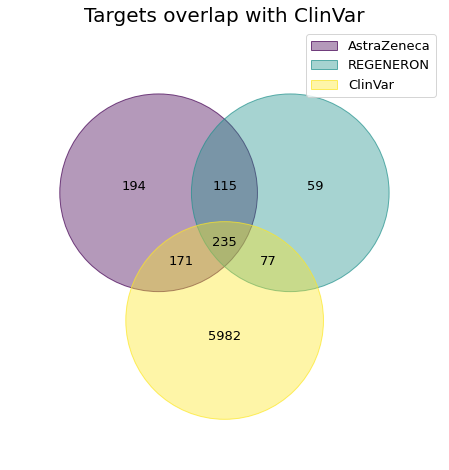

In [33]:
# Is REGENERON providing the novel targets? No

tmp = (
    spark.read.parquet('/Users/irene/Documents/dev/pyspark/22.04.4/associationByDatasourceIndirect')
    .filter((F.col('datasourceId') == 'eva') | (F.col('datasourceId') == 'eva_somatic'))
    .select('targetId').distinct())

targets_overlap_sets = {
    'AstraZeneca': set(
        az_assocs.select('targetId').distinct().toPandas()['targetId'].tolist()
    ),
    'REGENERON': set(
        regeneron_assocs.select('targetId').distinct().toPandas()['targetId'].tolist()
    ),
    'ClinVar': set(
        tmp.toPandas()['targetId'].tolist()
    )
}

venn(targets_overlap_sets, legend_loc="best")
plt.title('Targets overlap with ClinVar', fontsize=20)

In [39]:
# Is the overlap only referring to associations based on PTVs? Apparently not...

bin_ptv_overlap_between_sources = (

    # I first get all common associations across sources for binary traits
    burden_indirect_assocs.filter(F.col('diseaseId').isin(gene_burden_bin_dis))

    # Keep only associations with PTVs
    .join(
        evd.filter(F.col('statisticalMethod').contains('ptv')).select('targetId', 'diseaseId').distinct(),
        on=['targetId', 'diseaseId'], how='inner'
    )

    .join(otp_indirect_assocs, how='inner', on=['targetId', 'diseaseId'])
    .distinct()

    # Break down by data source and percentage relative to the total number of associations
    .groupBy('datasourceId').count()
    .withColumn('percentageOverlap', F.col('count') / num_gene_burden_bin_assocs * 100)
    .withColumn('prettyDatasourceId', F.col('datasourceId')).replace(to_replace=PRETTY_DATASOURCE_NAMES, subset=['prettyDatasourceId'])
)

quant_ptv_overlap_between_sources = (

    # I first get all common associations across sources for quantitative traits
    burden_indirect_assocs.filter(~F.col('diseaseId').isin(gene_burden_bin_dis))

    # Keep only associations with PTVs
    .join(
        evd.filter(F.col('statisticalMethod').contains('ptv')).select('targetId', 'diseaseId').distinct(),
        on=['targetId', 'diseaseId'], how='inner'
    )

    .join(otp_indirect_assocs, how='inner', on=['targetId', 'diseaseId'])
    .distinct()

    # Break down by data source and percentage relative to the total number of associations
    .groupBy('datasourceId').count()
    .withColumn('percentageOverlap', F.col('count') / num_gene_burden_quant_assocs * 100)
    .withColumn('prettyDatasourceId', F.col('datasourceId')).replace(to_replace=PRETTY_DATASOURCE_NAMES, subset=['prettyDatasourceId'])
)

fig7b = make_subplots(
    rows=1, cols=2, shared_yaxes=True, specs=[[{"type": "xy"}, {"type": "xy"}]],
    x_title='Overlap (%)', # y_title='Data source',
    subplot_titles=('Binary traits', 'Quantitative traits'),
)

fig7b.add_trace(go.Bar(
    x=bin_ptv_overlap_between_sources.toPandas()['percentageOverlap'],
    y=bin_ptv_overlap_between_sources.toPandas()['prettyDatasourceId'],
    orientation='h',
    hovertemplate='%{y}: %{x}%<extra></extra>',
    ), row=1, col=1)

fig7b.add_trace(go.Bar(
    x=quant_ptv_overlap_between_sources.toPandas()['percentageOverlap'],
    y=quant_ptv_overlap_between_sources.toPandas()['prettyDatasourceId'],
    orientation='h',
    hovertemplate='%{y}: %{x}%<extra></extra>',
    ), row=1, col=2)

# fig7.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)

fig7b.update_layout(
    title_text="Overlap between PTV based gene burden associations and other sources",
    xaxis_range=[0,60],
    showlegend=False, height=600)
#py.plot(fig7, filename = 'assoc_ot_burden_overlap', auto_open=True)
fig7b.show()

### 2. PheWAS plot with all data sources. (X-axis: traits ordered by TA; Y-axis:-log2 assoc score)

In [70]:
# Snippet to extract most relevant TA - also used in V2D

THERAPEUTIC_AREAS = {
    # I had to add 'OTAR_0000020' (nutritional or metabolic disease) and 'MONDO_0100336' (infectious disease or post-infectious disorder)
    # because they were not in the list
    'therapeutic_area': [
        'cell proliferation disorder',
        'infectious disease',
        'infectious disease or post-infectious disorder',
        'pregnancy or perinatal disease',
        'animal disease',
        'disease of visual system',
        'cardiovascular disease',
        'pancreas disease',
        'gastrointestinal disease',
        'reproductive system or breast disease',
        'integumentary system disease',
        'endocrine system disease',
        'nutritional or metabolic disease',
        'respiratory or thoracic disease',
        'urinary system disease',
        'musculoskeletal or connective tissue disease',
        'disease of ear',
        'immune system disease',
        'hematologic disease',
        'nervous system disease',
        'psychiatric disorder',
        'nutritional or metabolic disease',
        'genetic, familial or congenital disease',
        'injury, poisoning or other complication',
        'phenotype',
        'measurement',
        'biological process',
    ],
    'id': [
        'MONDO_0045024',
        'EFO_0005741',
        'MONDO_0100336',
        'OTAR_0000014',
        'EFO_0005932',
        'MONDO_0024458',
        'EFO_0000319',
        'EFO_0009605',
        'EFO_0010282',
        'OTAR_0000017',
        'EFO_0010285',
        'EFO_0001379',
        'OTAR_0000020',
        'OTAR_0000010',
        'EFO_0009690',
        'OTAR_0000006',
        'MONDO_0021205',
        'EFO_0000540',
        'EFO_0005803',
        'EFO_0000618',
        'MONDO_0002025',
        'MONDO_0024297',
        'OTAR_0000018',
        'OTAR_0000009',
        'EFO_0000651',
        'EFO_0001444',
        'GO_0008150',
    ],
}
SORTED_TAS_DF = pd.DataFrame(data=THERAPEUTIC_AREAS)

def get_prioritised_therapeutic_area(
    therapeutic_areas,
) -> str:
    """
    SORTED_TAS_DF is a df where the therapeutic areas are arranged in order of relevance.
    The more relevant TA is extracted by selecting which one has the minimal index.
    """
    try:
        if len(therapeutic_areas) > 0:
            min_index = float('inf')
            for ta in therapeutic_areas:
                idx = SORTED_TAS_DF.index[SORTED_TAS_DF['id'] == ta]
                if idx < min_index:
                    min_index = idx
            ta = SORTED_TAS_DF.iloc[min_index]["therapeutic_area"].values[0]
            return ta
    except TypeError:
        return "Uncategorised"
    except Exception as e:
        raise e

In [71]:
ind_assocs = (
    spark.read.parquet('/Users/irenelopez/Documents/dev/pyspark/22.11/associationByDatasourceIndirect')
    .select('datasourceId', 'diseaseId', 'targetId', 'score')

    # Get list of therapeutic areas from disease index
    .join(
        spark.read.parquet(Path.joinpath(ROOT / 'data/diseases').as_posix()).select(F.col('id').alias('diseaseId'), 'therapeuticAreas'),
        on='diseaseId', how='left'
    )
)

ind_assocs.show(5)

+-----------+------------+---------------+--------------------+----------------+
|  diseaseId|datasourceId|       targetId|               score|therapeuticAreas|
+-----------+------------+---------------+--------------------+----------------+
|EFO_0000595|   europepmc|ENSG00000075624|0.012158615952232422| [MONDO_0045024]|
|EFO_0000595|   europepmc|ENSG00000125618| 0.01823792392834863| [MONDO_0045024]|
|EFO_0000595|   europepmc|ENSG00000135903| 0.03647584785669726| [MONDO_0045024]|
|EFO_0000595|   europepmc|ENSG00000171791|0.030396539880581056| [MONDO_0045024]|
|EFO_0000595|   europepmc|ENSG00000175084|0.012158615952232422| [MONDO_0045024]|
+-----------+------------+---------------+--------------------+----------------+
only showing top 5 rows



In [72]:
# Logic is built with Pandas

ind_diseases_pdf = ind_assocs.select('diseaseId', 'therapeuticAreas').distinct().toPandas()
ind_diseases_pdf['therapeuticCategory'] = (
    ind_diseases_pdf['therapeuticAreas'].apply(get_prioritised_therapeutic_area)   
)

ind_diseases_pdf


/var/folders/54/2j7x_lqn343_d6hjm7mcv9rc0000gn/T/ipykernel_8715/1604393622.py:79: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



,diseaseId,therapeuticAreas,therapeuticCategory
0,EFO_0009177,[EFO_0001444],measurement
1,EFO_0009904,"[OTAR_0000018, EFO_0000618]",nervous system disease
2,EFO_0009938,[EFO_0001444],measurement
3,EFO_0007633,[GO_0008150],biological process
4,EFO_0009167,[GO_0008150],biological process
...,...,...,...
16595,EFO_1000653,[OTAR_0000006],musculoskeletal or connective tissue disease
16596,EFO_0002502,"[EFO_0001379, EFO_0000540, EFO_0009605, EFO_00...",pancreas disease
16597,Orphanet_98806,"[OTAR_0000018, EFO_0000618]",nervous system disease
16598,HP_0000974,[EFO_0000651],phenotype


In [79]:
ind_assocs = (
    ind_assocs.join(spark.createDataFrame(ind_diseases_pdf[['diseaseId', 'therapeuticCategory']]), on='diseaseId', how='left')
    .withColumn('log2score', -F.log2(1 - F.col('score')))
)

ind_assocs.show(5)

+-----------+------------+---------------+--------------------+----------------+--------------------+--------------------+
|  diseaseId|datasourceId|       targetId|               score|therapeuticAreas| therapeuticCategory|           log2score|
+-----------+------------+---------------+--------------------+----------------+--------------------+--------------------+
|EFO_0000595|   europepmc|ENSG00000075624|0.012158615952232422| [MONDO_0045024]|cell proliferatio...|0.017648685484778454|
|EFO_0000595|   europepmc|ENSG00000125618| 0.01823792392834863| [MONDO_0045024]|cell proliferatio...|  0.0265546561525172|
|EFO_0000595|   europepmc|ENSG00000135903| 0.03647584785669726| [MONDO_0045024]|cell proliferatio...|0.053607264650065045|
|EFO_0000595|   europepmc|ENSG00000171791|0.030396539880581056| [MONDO_0045024]|cell proliferatio...|0.044533247676932175|
|EFO_0000595|   europepmc|ENSG00000175084|0.012158615952232422| [MONDO_0045024]|cell proliferatio...|0.017648685484778454|
+-----------+---

In [ ]:
'''fig8 = px.scatter(
    ind_assocs_pdf,
    x='therapeuticCategory', y='log2score',
    title='PheWAS',
)

fig8.show()'''

# Plotly Express is not able to handle millions of data points

In [ ]:
# I'll try with Datashader - not ideal / only numerical variables are allowed

'''import holoviews as hv
import datashader as ds

hv.extension('bokeh')

agg = ds.Canvas().points(ind_assocs_pdf.head(1000),'therapeuticCategory','log2score')
'''


In [50]:
import plotly.offline as pyo

# I want to color the points per data source. 
# That is not implemented by default in Scattergl, so I have to add the traces manually per source
groups = ind_assocs_pdf.datasourceId.unique()

# Create as many traces as different groups there are and save them in data list
data = []
for source in groups:
    df_group = ind_assocs_pdf[ind_assocs_pdf['datasourceId'] == source]
    if source != 'gene_burden':
        trace = go.Scattergl(x=df_group['therapeuticCategory'], 
                            y=df_group['log2score'],
                            mode='markers',
                            name=source,
                            customdata=df_group['targetId'],
                            hovertemplate = "Target: %{customdata} <br>-log2 score: %{y} </br> Therapeutic area:%{x}",
                            visible='legendonly')
    else:
        trace = go.Scattergl(x=df_group['therapeuticCategory'], 
                    y=df_group['log2score'],
                    mode='markers',
                    name=source,
                    customdata=df_group['targetId'],
                    hovertemplate = "Target: %{customdata} <br>-log2 score: %{y} </br> Therapeutic area:%{x}",
                )
    data.append(trace)

# Layout of the plot
layout = go.Layout(
    title='PheWAS <br><sup>Strength of association map (sample of 7 000 associations)</sup>',
    xaxis={'title': 'Therapeutic areas'},
    yaxis={'title': '-log2 score'},
)
fig8 = go.Figure(data=data, layout=layout)

#pyo.plot(fig8)
#py.plot(fig8, filename = 'phewas', auto_open=True) 

#fig8.show()

### A less noisy way of displaying distribution of associations

Stacked bar chart per therapeutic area with 3 groups:
-  number of associations in OTP (unselected by default)
-  number of associations in both
-  number of new associations from gene burden

In [84]:
total_assocs_df = (
    ind_assocs.filter(F.col('datasourceId') != 'gene_burden')
    .select(F.concat_ws("|", "targetId", "diseaseId").alias("assoc"), "therapeuticCategory")
    .distinct()
    .groupBy("therapeuticCategory").count()
    .withColumn("metric", F.lit("Associations in OT Platform"))
    .toPandas()
)


total_assocs_df.head(5)


,therapeuticCategory,count,metric
0,infectious disease,204619,Associations in OT Platform
1,urinary system disease,120908,Associations in OT Platform
2,reproductive system or breast disease,245595,Associations in OT Platform
3,infectious disease or post-infectious disorder,20305,Associations in OT Platform
4,"injury, poisoning or other complication",11673,Associations in OT Platform


In [86]:
new_burden_assocs_df = (
    ind_assocs.filter(F.col('datasourceId') == 'gene_burden')
    .select(F.concat_ws("|", "targetId", "diseaseId").alias("assoc"), "therapeuticCategory")
    .distinct()
    .join(
        (
            ind_assocs.filter(F.col('datasourceId') != 'gene_burden')
            .select(F.concat_ws("|", "targetId", "diseaseId").alias("assoc")).distinct()
        ),
        on='assoc',
        how='left_anti'
    ).distinct()
    .groupBy("therapeuticCategory").count()
    .withColumn("metric", F.lit("Novel gene burden associations"))
    .toPandas()
)


new_burden_assocs_df.head()


,therapeuticCategory,count,metric
0,infectious disease,21,Novel gene burden associations
1,urinary system disease,23,Novel gene burden associations
2,reproductive system or breast disease,22,Novel gene burden associations
3,"injury, poisoning or other complication",12,Novel gene burden associations
4,cardiovascular disease,100,Novel gene burden associations


In [87]:
overlap_assocs_df = (
    ind_assocs.filter(F.col('datasourceId') == 'gene_burden')
    .select(F.concat_ws("|", "targetId", "diseaseId").alias("assoc"), "therapeuticCategory")
    .distinct()
    .join(
        (
            ind_assocs.filter(F.col('datasourceId') != 'gene_burden')
            .select(F.concat_ws("|", "targetId", "diseaseId").alias("assoc")).distinct()
        ),
        on='assoc',
        how='inner'
    ).distinct()
    .groupBy("therapeuticCategory").count()
    .withColumn("metric", F.lit("Overlapping associations"))
    .toPandas()
)


overlap_assocs_df.head(5)


,therapeuticCategory,count,metric
0,infectious disease,20,Overlapping associations
1,urinary system disease,59,Overlapping associations
2,reproductive system or breast disease,59,Overlapping associations
3,infectious disease or post-infectious disorder,11,Overlapping associations
4,cardiovascular disease,206,Overlapping associations


In [88]:
stacked_df = pd.concat([total_assocs_df, new_burden_assocs_df, overlap_assocs_df], axis=0).drop_duplicates().reset_index()

stacked_df.head(10)

,index,therapeuticCategory,count,metric
0,0,infectious disease,204619,Associations in OT Platform
1,1,urinary system disease,120908,Associations in OT Platform
2,2,reproductive system or breast disease,245595,Associations in OT Platform
3,3,infectious disease or post-infectious disorder,20305,Associations in OT Platform
4,4,"injury, poisoning or other complication",11673,Associations in OT Platform
5,5,cardiovascular disease,295213,Associations in OT Platform
6,6,respiratory or thoracic disease,129779,Associations in OT Platform
7,7,measurement,541725,Associations in OT Platform
8,8,disease of visual system,314328,Associations in OT Platform
9,9,"genetic, familial or congenital disease",372516,Associations in OT Platform


In [89]:
stacked_df.metric.value_counts()

Associations in OT Platform       27
Novel gene burden associations    26
Overlapping associations          26
Name: metric, dtype: int64

In [100]:
'''fig9 = px.bar(
    stacked_df, x='count', y='therapeuticCategory', color='metric', orientation='h',
    title='Association count per therapeutic area', height=600,
)
#fig9.update_layout(title_text="Associations overlap between gene burden and other sources", showlegend=False, height=600)

fig9.show()''')

'fig9 = px.bar(\n    stacked_df, x=\'count\', y=\'therapeuticCategory\', color=\'metric\', orientation=\'h\',\n    title=\'Association count per therapeutic area\', height=600,\n)\n#fig9.update_layout(title_text="Associations overlap between gene burden and other sources", showlegend=False, height=600)\n\nfig9.show()'

In [90]:
# I want to unselect the total count of OTP by default, so I have to add the traces manually per type of metric
groups = ['Associations in OT Platform', 'Overlapping associations', 'Novel gene burden associations']

# Create as many traces as different groups there are and save them in data list
data = []
for metric in groups:
    df_group = stacked_df[stacked_df['metric'] == metric]
    if metric == 'Associations in OT Platform':
        trace = go.Bar(x=df_group['count'], 
                            y=df_group['therapeuticCategory'],
                            name=metric,
                            orientation='h',
                            visible='legendonly')
    else:
        trace = go.Bar(x=df_group['count'], 
                            y=df_group['therapeuticCategory'],
                            name=metric,
                            orientation='h',
                )
    data.append(trace)

# Layout of the plot
layout = go.Layout(
    title='Novel associations from gene burden analysis',
    xaxis={'title': 'Number of gene (or target)-trait associations'},
    yaxis={'title': 'Therapeutic areas'},
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
        ),
    barmode='stack'
)

fig9 = go.Figure(data=data, layout=layout)



#pyo.plot(fig9)
py.plot(fig9, filename = 'ta_distribution', auto_open=True)

fig9.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Less noise: distribution of overlap and novelty considering only **non genetic sources**

- Build the same plot as above but with a different set of associations:
  1. Build associations set with datatype and source
  2. Remove genetic associations unless they're coming from gene_burden
  3. Repeat steps as section below

In [125]:
assocs_by_datatype = (
    pd.read_parquet('/Users/irene/Documents/dev/pyspark/22.04.4/associationByDatatypeIndirect')
    .filter(items=['diseaseId', 'targetId', 'datatypeId'])
)

In [128]:
ind_assocs_pdf = (
    ind_assocs_pdf
    .merge(assocs_by_datatype, on=['diseaseId', 'targetId'], how='inner')
)

ind_assocs_pdf.head(5)

,diseaseId,datasourceId,targetId,score,therapeuticAreas,therapeuticCategory,log2score,datatypeId
0,OTAR_0000014,eva_somatic,ENSG00000008086,0.577534,[OTAR_0000014],pregnancy or perinatal disease,0.792022,animal_model
1,OTAR_0000014,eva_somatic,ENSG00000008086,0.577534,[OTAR_0000014],pregnancy or perinatal disease,0.792022,genetic_association
2,OTAR_0000014,eva_somatic,ENSG00000008086,0.577534,[OTAR_0000014],pregnancy or perinatal disease,0.792022,literature
3,OTAR_0000014,eva_somatic,ENSG00000008086,0.577534,[OTAR_0000014],pregnancy or perinatal disease,0.792022,somatic_mutation
4,OTAR_0000014,genomics_england,ENSG00000008086,0.827461,[OTAR_0000014],pregnancy or perinatal disease,0.273236,animal_model


In [ ]:
non_genetic_total_assocs_df = (
    ind_assocs_pdf.query('datatypeId != "genetic_association"')
    .assign(assoc=lambda x: f'{x.targetId}|{x.diseaseId}')
    .groupby('therapeuticCategory')
    .agg(count=('assoc', 'count'))
    .assign(metric='Associations in OT Platform')
)


non_genetic_total_assocs_df.head(5)


## Are the 